Modelo cargado correctamente desde:
../results/models/dqn/best_model/best_model.zip

RESULTADO TEST FINAL
Recompensa total en Test: 100.68
Promedio diario: 1.1187
Máximo inventario: 1059.0


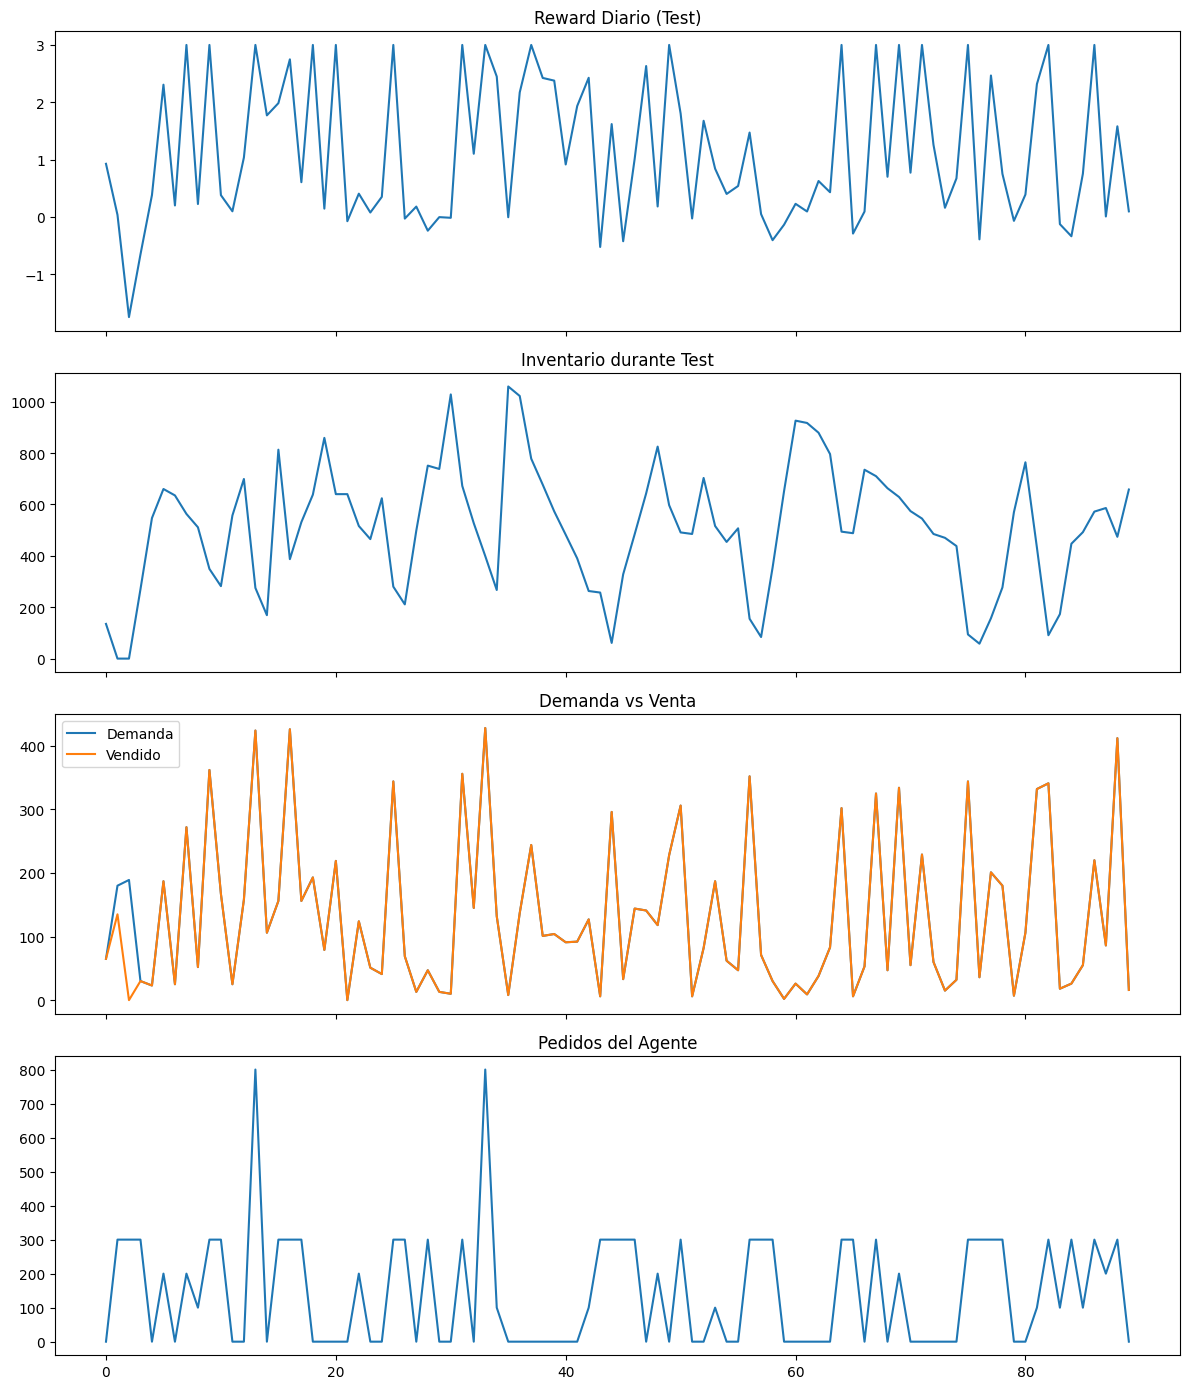

In [ ]:
# Script de evaluación Train/Test para DQN
# Usa el modelo entrenado previamente en training_dqn.py
import os
import sys
import yaml
import pickle
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

# Importar entorno
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.environment_dqn import RetailEnvDQN

output_path = '../results/plots/test_split/' # Para guardar los plots
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# 1. Cargar configuración y dataset
CONFIG_FILE = "../configs/ultra_fast.yaml"
with open(CONFIG_FILE, "r") as f:
    cfg = yaml.safe_load(f)

STORES_PATH = "../data/stores.pkl"

# 2. Cargar tiendas (stores)
with open(STORES_PATH, "rb") as f:
    stores = pickle.load(f)

# Ocupamos el mismo split que en training_dqn
store_ids = list(stores.keys())
store_ids.sort()

split_idx = int(len(store_ids) * 0.8)
train_stores = {sid: stores[sid] for sid in store_ids[:split_idx]}
eval_stores  = {sid: stores[sid] for sid in store_ids[split_idx:]}


# 2. Crear entorno de evaluación
def make_env_test():
    env = RetailEnvDQN(eval_stores)
    env.disable_random_reset = True   # inicio fijo
    env.fixed_start = 0               # usa el primer día del test
    env.reset(seed=123)               # para la reproducibilidad
    return env

env_test = make_env_test()


# 3. Cargar modelo entrenado
model_path = "../results/models/dqn/best_model/best_model.zip"

if not os.path.exists(model_path):
    raise FileNotFoundError(f"No existe el modelo entrenado: {model_path}")

model = DQN.load(model_path, env=DummyVecEnv([lambda: RetailEnvDQN(train_stores)]))

print(f"Modelo cargado correctamente desde:\n{model_path}")


# 4. Evaluación determinística (Test)
obs, _ = env_test.reset()

rewards_test = []
inventory_trace = []
demand_trace = []
pedido_trace = []
vendido_trace = []

terminated = False
truncated = False

total_reward_test = 0

while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env_test.step(action)

    rewards_test.append(reward)
    inventory_trace.append(info["inventario"])
    demand_trace.append(info["demanda"])
    pedido_trace.append(info["pedido_qty"])
    vendido_trace.append(info["vendido"])

    total_reward_test += reward


print("\n======================")
print("RESULTADO TEST FINAL")
print("======================")
print(f"Recompensa total en Test: {total_reward_test:.2f}")
print(f"Promedio diario: {np.mean(rewards_test):.4f}")
print(f"Máximo inventario: {max(inventory_trace)}")


# 5. Graficar resultados
fig, axs = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

axs[0].plot(rewards_test)
axs[0].set_title("Reward Diario (Test)")

axs[1].plot(inventory_trace)
axs[1].set_title("Inventario durante Test")

axs[2].plot(demand_trace, label="Demanda")
axs[2].plot(vendido_trace, label="Vendido")
axs[2].legend()
axs[2].set_title("Demanda vs Venta")

axs[3].plot(pedido_trace)
axs[3].set_title("Pedidos del Agente")

plt.tight_layout()
plt.savefig(output_path + 'resultados.png')
plt.show()
